### `Step-7` : YOLO Model Training
- In the final step, I trained the model using YOLOv8 with the yolov8s (small) version. After completing the augmentation process, the dataset included both raw and augmented images, their corresponding labels, a classes.txt file, and a JSON file (which is not required for training).To train YOLOv8, it is essential to organize the dataset in the correct folder structure. The folder structure should look like this:



```project/
├── images/
│   ├── train/
│   │   └── image1.jpg
│   ├── valid/
│   │   └── image2.jpg
│   └── test/
│       └── image3.jpg
│
├── labels/
│   ├── train/
│   │   └── image1.txt
│   ├── valid/
│   │   └── image2.txt
│   └── test/
│       └── image3.txt
│
├── data.yaml         # Configuration file for the dataset
├── train.txt         # List of image paths for training
├── valid.txt         # List of image paths for validation
└── test.txt          # List of image paths for testing (Optional)
```


-  The `data.yaml` file is a crucial configuration file for YOLO models. It tells the training script where to find your dataset and defines the classes you're training on. The structure of the data.yaml file should look like this:


```# Path to the dataset folder
path: C:/Users/mesut/Desktop/yolo_completed 

# Train, validation, and test splits
train: train.txt
val: valid.txt
test: test.txt

# Number of classes
nc: 8

# Class names (in order)
names:
  0: 'bear'
  1: 'crocodile'
  2: 'hawk'
  3: 'lion'
  4: 'scorpion'
  5: 'snake'
  6: 'spider'
  7: 'wolf'
```


In [8]:
#pip install ultralytics
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
import torch
import torchvision
import os
import shutil
import glob
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image

I have an NVIDIA RTX 4070 graphics card, which supports GPU acceleration. To take advantage of faster training, I installed CUDA 12.4, which is compatible with my GPU and the YOLOv8 training environment.

In [2]:
# Check PyTorch and CUDA setup
print(f"PyTorch version: {torch.__version__}")                    # PyTorch version
print(f"CUDA version: {torch.version.cuda}")                      # CUDA toolkit version
print(f"Torchvision version: {torchvision.__version__}")          # Torchvision version
print(f"CUDA available: {torch.cuda.is_available()}")             # True if GPU is available
print(f"CUDA device: {torch.cuda.get_device_name(0)}")            # GPU device name

PyTorch version: 2.6.0+cu124
CUDA version: 12.4
Torchvision version: 0.21.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 Laptop GPU


In [3]:
# Create a 5x5 tensor on GPU
x = torch.rand(5, 5).cuda()
print(x)

tensor([[3.8140e-01, 9.7586e-01, 1.6759e-01, 7.6290e-01, 8.4085e-01],
        [4.4483e-01, 1.3893e-01, 9.9001e-01, 6.6034e-01, 6.1926e-01],
        [4.4157e-01, 8.3122e-01, 1.0360e-01, 8.5839e-01, 6.6024e-01],
        [2.1458e-04, 9.8053e-01, 9.9571e-02, 3.1769e-01, 7.9311e-01],
        [3.8580e-01, 8.1833e-02, 4.6445e-01, 7.5535e-01, 5.0976e-02]], device='cuda:0')


### Splitting the dataset into training, validation, and test sets

The following code snippet splits the images and labels into 80% training, 10% validation, and 10% test sets randomly, while ensuring that each image is matched with its corresponding label file by name.

In [ ]:
# === Setup paths ===
base_path = 'C:/Users/mesut/Desktop/yolo_completed'
image_dir = os.path.join(base_path, 'images')
label_dir = os.path.join(base_path, 'labels')

# Create subfolders if missing
for folder in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(image_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(label_dir, folder), exist_ok=True)

# === Step 1: Clear previous .txt splits ===
for filename in ['train.txt', 'valid.txt', 'test.txt']:
    open(os.path.join(base_path, filename), 'w').close()

print("✅ Cleared train.txt, valid.txt, test.txt")

# === Step 2: Find all image files ===
all_images = glob.glob(os.path.join(image_dir, '**', '*.jpg'), recursive=True)

# === Step 3: Move images and labels to target folders ===
def move_files(files, target_folder):
    moved_count = 0
    for img_file in files:
        label_file = img_file.replace('images', 'labels').replace('.jpg', '.txt')
        target_img = os.path.join(image_dir, target_folder, os.path.basename(img_file))
        target_label = os.path.join(label_dir, target_folder, os.path.basename(label_file))

        if os.path.exists(img_file) and not os.path.exists(target_img):
            shutil.move(img_file, target_img)
            moved_count += 1
        if os.path.exists(label_file) and not os.path.exists(target_label):
            shutil.move(label_file, target_label)

    print(f"✅ Moved {moved_count} files to '{target_folder}'")

# === Step 4: Split dataset (80/10/10) ===
num_train = int(0.8 * len(all_images))
num_valid = int(0.1 * len(all_images))
num_test = len(all_images) - (num_train + num_valid)

train_files = all_images[:num_train]
valid_files = all_images[num_train:num_train + num_valid]
test_files = all_images[num_train + num_valid:]

# === Step 5: Move files to folders ===
move_files(train_files, 'train')
move_files(valid_files, 'valid')
move_files(test_files, 'test')

# === Step 6: Write image paths to split files ===
def write_split(files, folder, filename):
    with open(os.path.join(base_path, filename), 'w') as f:
        for file in files:
            path = f"{base_path}/images/{folder}/{os.path.basename(file)}"
            f.write(path + '\n')

write_split(train_files, 'train', 'train.txt')
write_split(valid_files, 'valid', 'valid.txt')
write_split(test_files, 'test', 'test.txt')

print("✅ Dataset organized and paths updated!")

# === Step 7: Print summary ===
print(f"🔎 Train files: {len(train_files)}")
print(f"🔎 Validation files: {len(valid_files)}")
print(f"🔎 Test files: {len(test_files)}")


### Parameters for YOLOv8 model

During the training step, I encountered a kernel error in Jupyter Notebook, even after trying different parameters. As a solution, I switched to JupyterLab and successfully trained the model there.

In [ ]:
# ======================
# STABLE CUDA SETTINGS
# ======================
torch.cuda.empty_cache()  # Clear GPU cache
torch.cuda.set_per_process_memory_fraction(0.8, 0)  # Limit memory usage per process

torch.backends.cudnn.benchmark = True  # Speed up training for fixed input size
torch.backends.cudnn.enabled = True

# Set thread limits for parallelism
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["TORCH_DISTRIBUTED_DEBUG"] = "DETAIL"  # Debug mode if needed

# ======================
# TRAIN YOLOv8
# ======================
model = YOLO('yolov8s.pt')  # Load pre-trained YOLOv8 small model

model.train(
    data='C:/Users/mesut/Desktop/yolo_completed/data.yaml',  # Dataset config
    epochs=100,            # Total training epochs
    imgsz=416,             # Image resolution
    batch=16,              # Batch size
    device='cuda',         # Use GPU
    optimizer='Adam',      # Optimizer
    lr0=0.0002,            # Initial learning rate
    patience=30,           # Early stopping patience
    augment=True,          # Enable data augmentation
    scale=0.5,             # Augmentation scale variation
    cache=False,           # Disable caching to save RAM
    plots=True,            # Show training plots
    workers=4              # Data loading workers
)


### Results of Training

In [2]:
# Load training results
results = pd.read_csv('C:/Users/mesut/runs/detect/train/results.csv')

# Show the first 5 rows
results.head()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,83.3912,1.11008,2.29777,1.27716,0.43810,0.48971,0.47762,0.32249,1.17725,1.75191,1.37849,0.067084,0.000066,0.000066
1,2,138.1300,0.98857,1.41747,1.18860,0.58484,0.59806,0.64367,0.45243,1.00753,1.51329,1.22882,0.033815,0.000131,0.000131
2,3,194.3270,0.94040,1.21907,1.15797,0.66292,0.67101,0.71986,0.53013,0.94007,1.22263,1.21103,0.000546,0.000195,0.000195
3,4,251.0740,0.91332,1.08936,1.14822,0.70355,0.76082,0.79842,0.59075,0.87310,1.01745,1.19006,0.000194,0.000194,0.000194
4,5,310.2140,0.86204,1.02377,1.13000,0.72555,0.82352,0.81335,0.61367,0.85337,0.93376,1.18421,0.000192,0.000192,0.000192


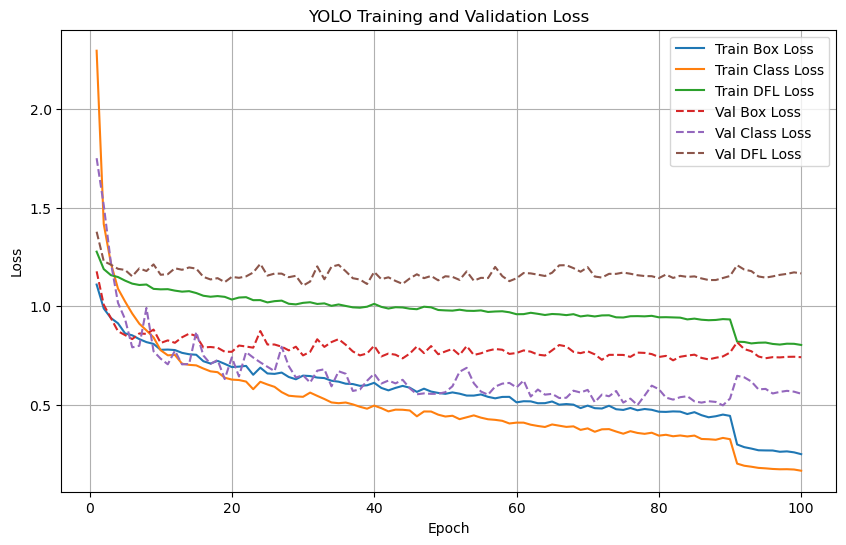

In [5]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['train/box_loss'], label='Train Box Loss')
plt.plot(results['epoch'], results['train/cls_loss'], label='Train Class Loss')
plt.plot(results['epoch'], results['train/dfl_loss'], label='Train DFL Loss')

# Plot validation loss
plt.plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', linestyle='--')
plt.plot(results['epoch'], results['val/cls_loss'], label='Val Class Loss', linestyle='--')
plt.plot(results['epoch'], results['val/dfl_loss'], label='Val DFL Loss', linestyle='--')

# Add labels and legend
plt.title('YOLO Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

- All training losses (box, class, DFL) steadily decrease, showing consistent and effective learning throughout the epochs.Validation losses go down at first but then stay mostly the same, especially the DFL loss. This means the model is learning, but it might not be improving much on new data and could be slightly overfitting.

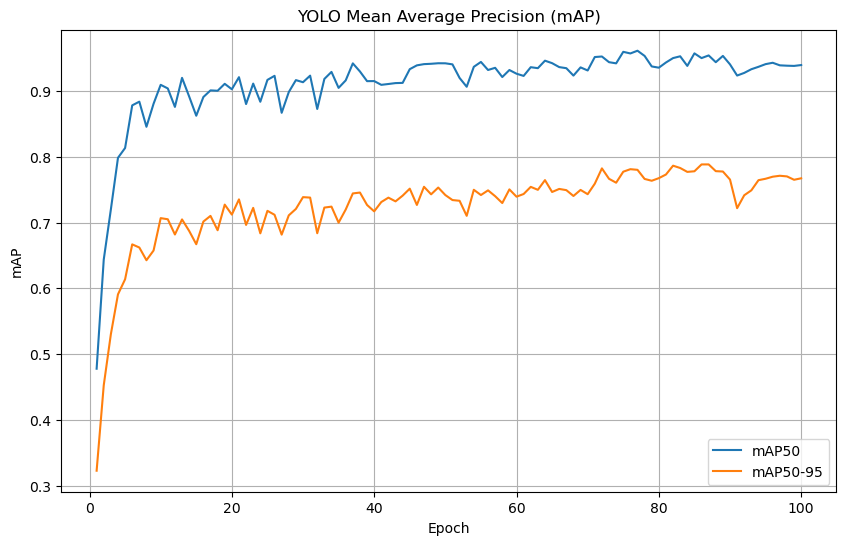

In [6]:
# Plot mAP values
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP50')
plt.plot(results['epoch'], results['metrics/mAP50-95(B)'], label='mAP50-95')

# Add labels and legend
plt.title('YOLO Mean Average Precision (mAP)')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid()
plt.show()


- `Blue line (mAP50):` The model is good at finding objects and keeps doing well over time.Orange line `(mAP50-95):` The model keeps getting better at locating objects more accurately, but it's a bit harder — so it improves more slowly.

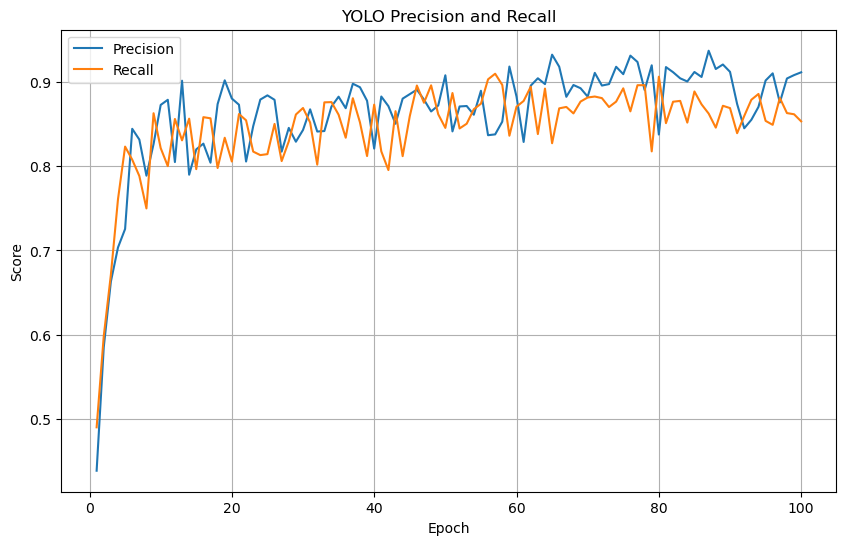

In [7]:
# Plot Precision and Recall
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['metrics/precision(B)'], label='Precision')
plt.plot(results['epoch'], results['metrics/recall(B)'], label='Recall')

# Add labels and legend
plt.title('YOLO Precision and Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


- `Precision:` tells you how many of the detections were actually correct.The model got better at making correct predictions early and stayed very accurate throughout training. `Recall:` tells you how many of the actual objects were found. The model improved at finding objects and stayed consistently good, though slightly less than precision.

### Confusion Matrix

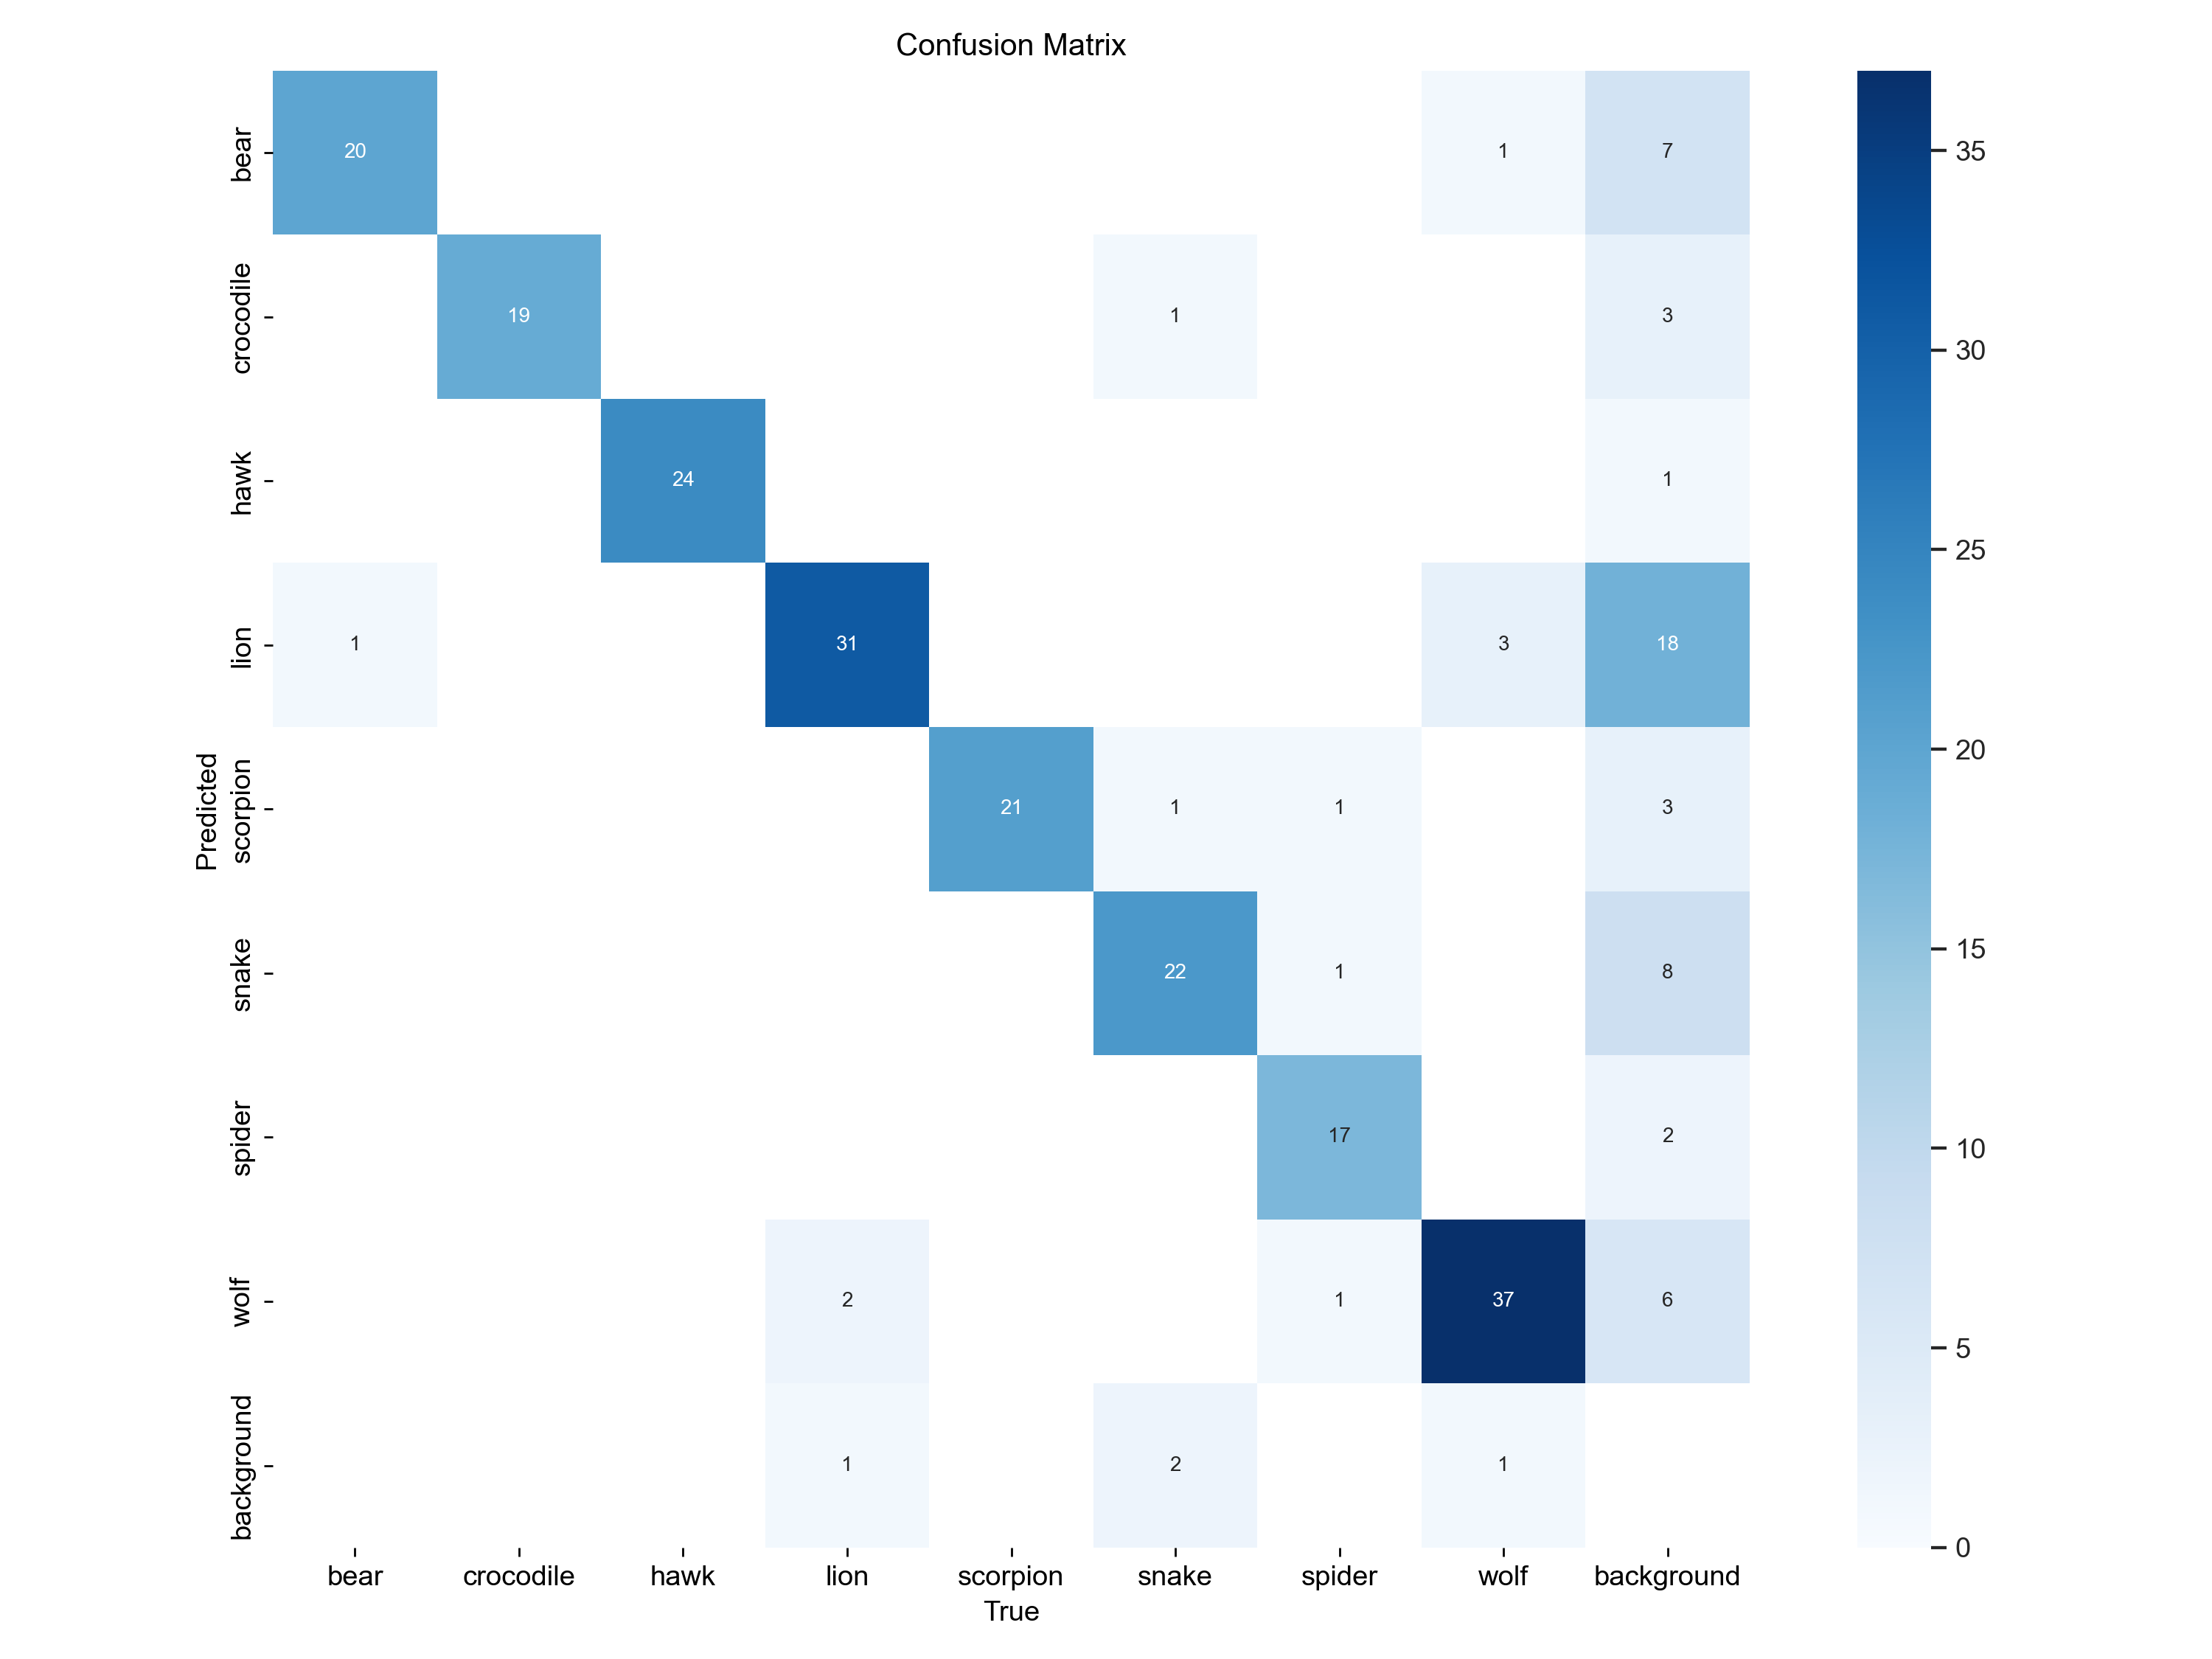

In [6]:
Image(filename='confusion_matrix.png')

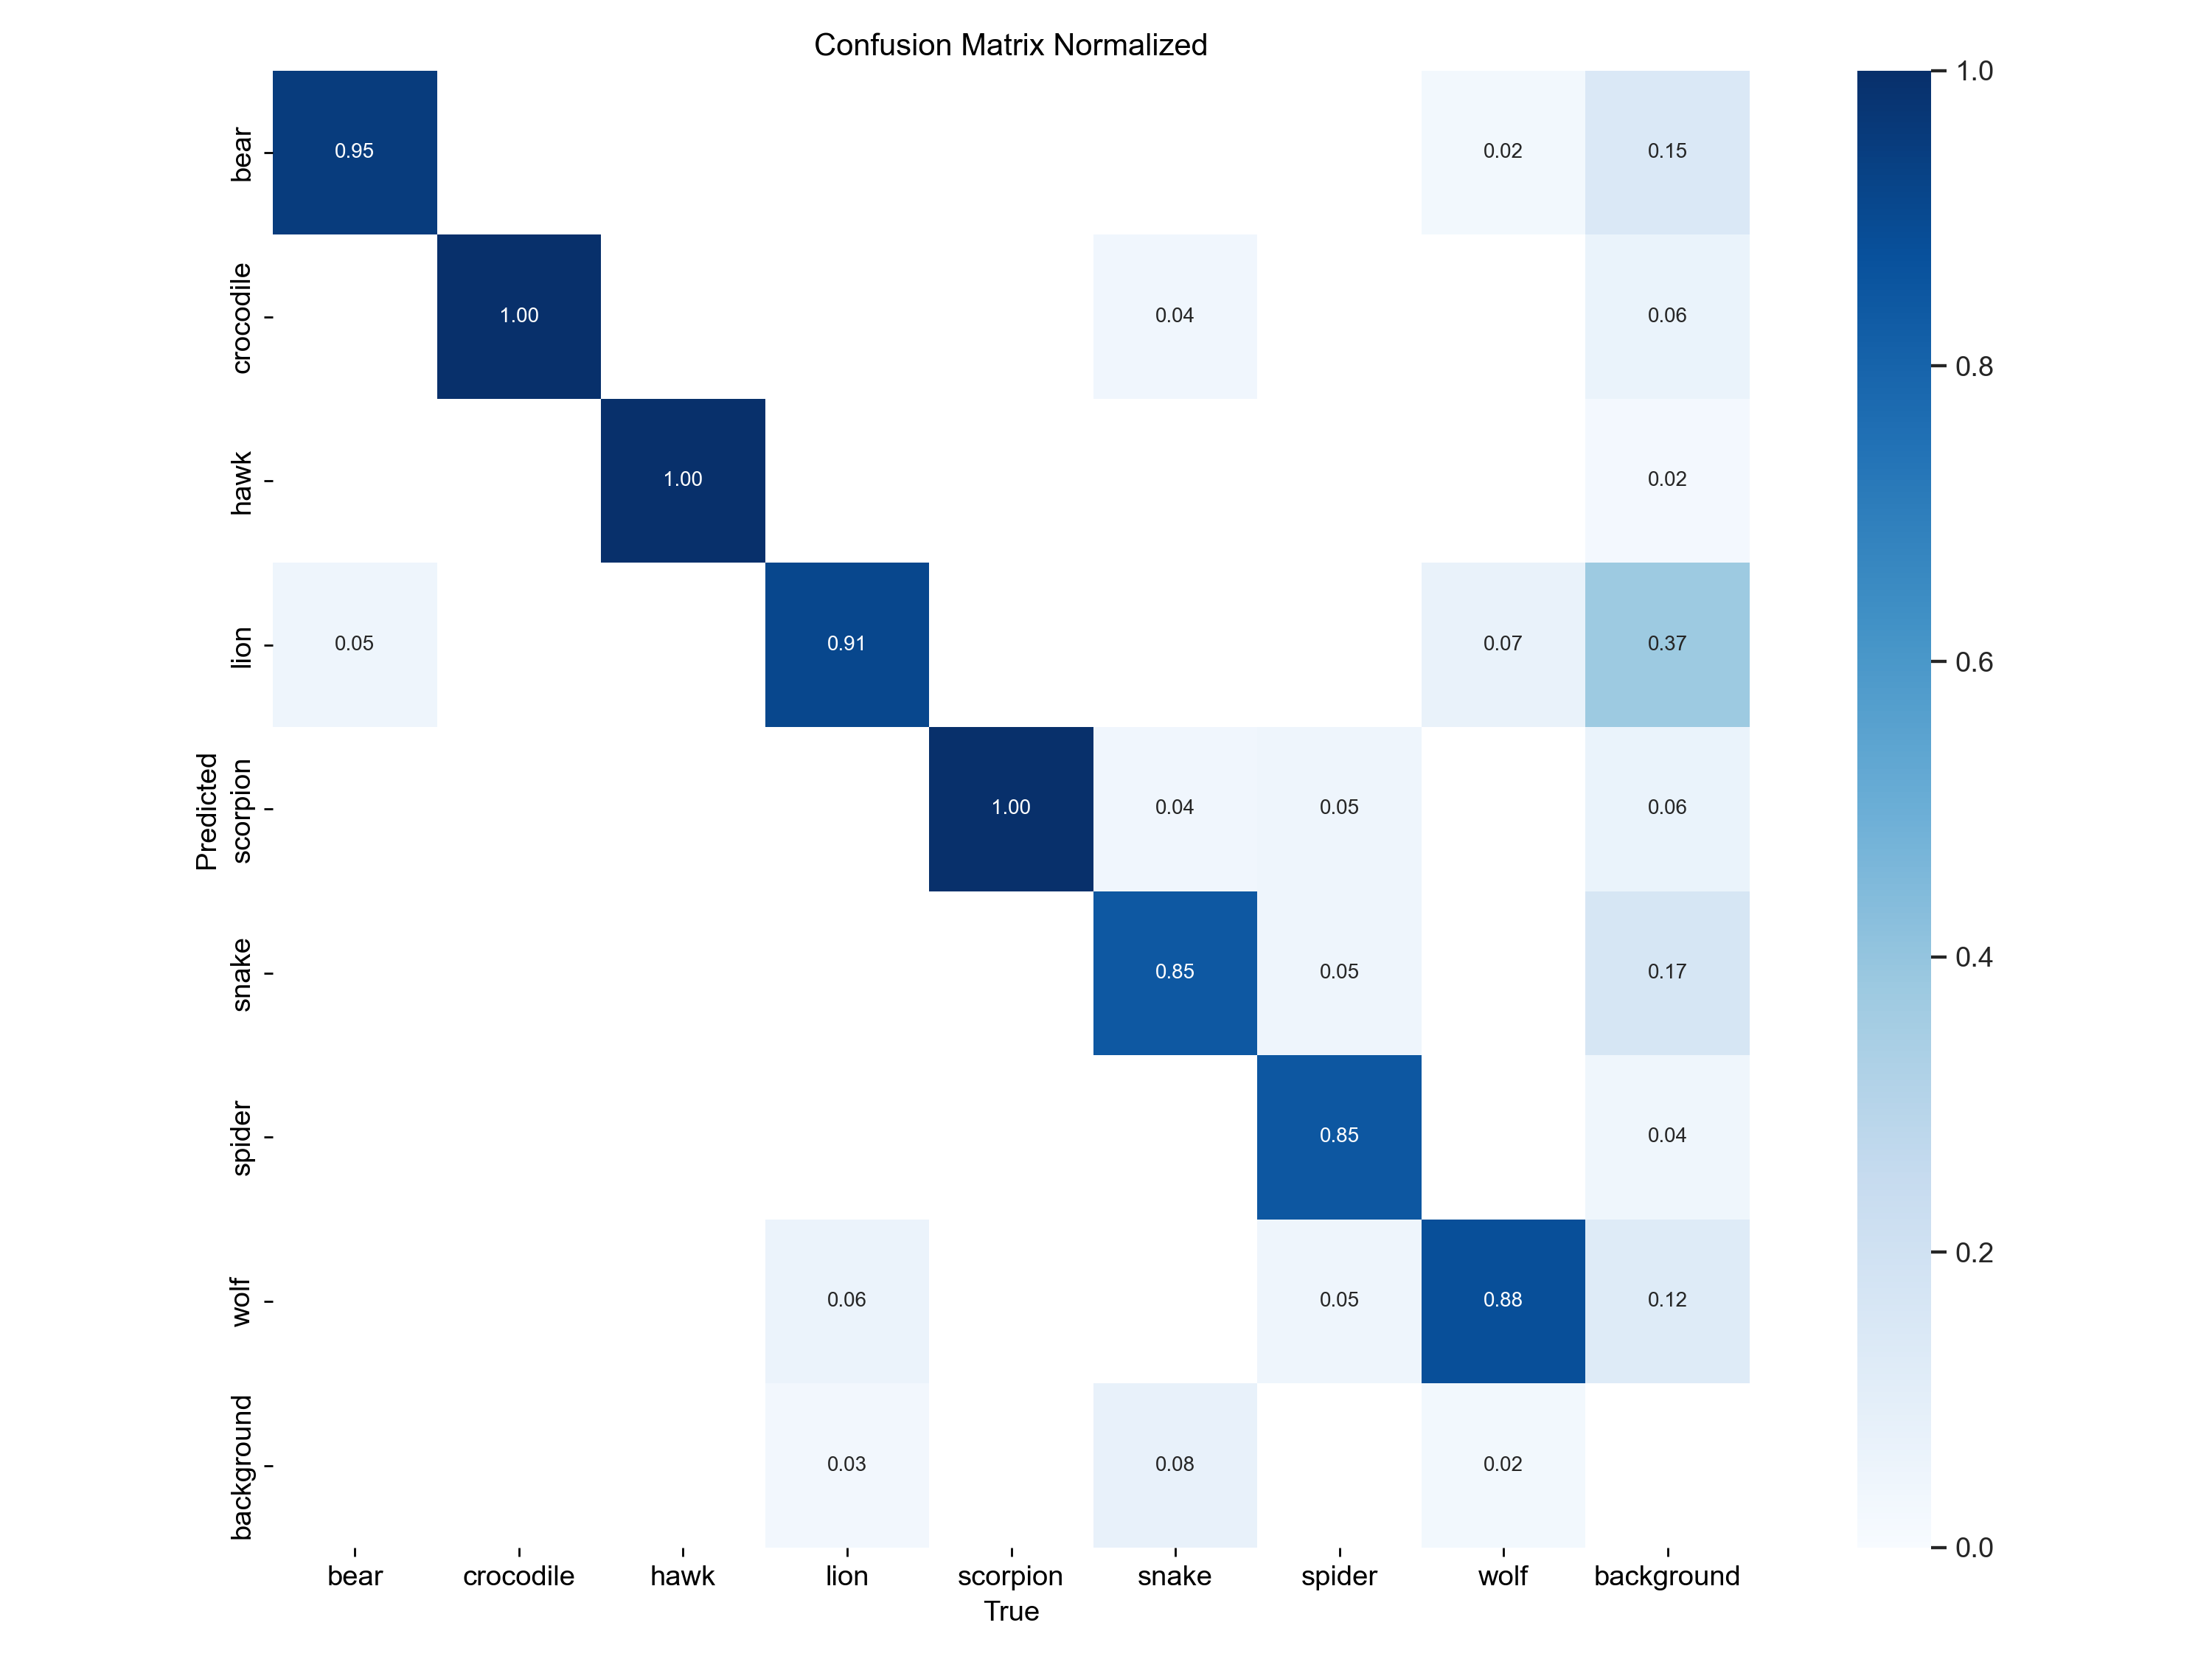

In [7]:
Image(filename='confusion_matrix_normalized.png')  # Adjust path if needed

- The model performs very well for classes like crocodile, hawk, and scorpion, with almost perfect accuracy. Lion, wolf, bear, and spider are also predicted fairly accurately, but there's still some room for improvement.These results show that the model has learned to recognize many classes quite well.
- Lions are often misclassified as wolves. Spiders and snakes are occasionally mixed up, likely due to visual similarities.

### Test 

In [3]:
# Load the best-performing model
model = YOLO('C:/Users/mesut/runs/detect/train/weights/best.pt')

Test for image folder


image 1/1 C:\Users\mesut\Desktop\xyz.png: 288x416 1 bear, 181.9ms
Speed: 15.2ms preprocess, 181.9ms inference, 411.1ms postprocess per image at shape (1, 3, 288, 416)
Results saved to runs\detect\predict2
✅ Loading result from: runs\detect\predict2\xyz.jpg


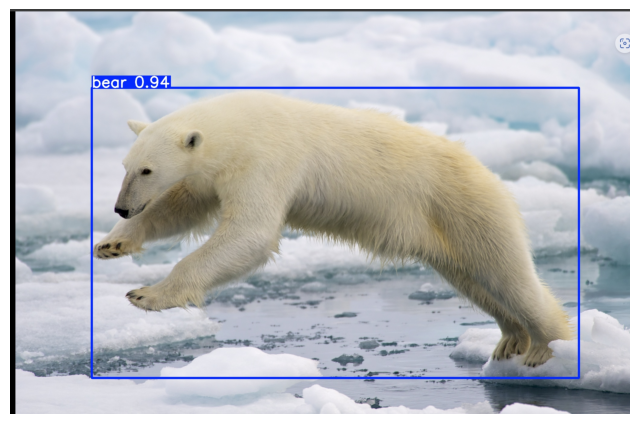

In [4]:
%matplotlib inline

# Run prediction
input_path = 'C:/Users/mesut/Desktop/xyz.png'
results = model.predict(input_path, save=True)

# Get the actual saved path
saved_path = results[0].save_dir

# Get the base filename (without extension)
base_filename = os.path.splitext(os.path.basename(input_path))[0]

# Search for any matching file (supports .jpg, .jpeg, .png, .bmp, .tiff, etc.)
pattern = os.path.join(saved_path, f"{base_filename}.*")
matching_files = glob.glob(pattern)

if matching_files:
    saved_file = matching_files[0]  # Get the first match
    print(f"✅ Loading result from: {saved_file}")

    # Load image using OpenCV
    result_image = cv2.imread(saved_file)

    if result_image is not None:
        # Convert BGR to RGB
        result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

        # Display with matplotlib
        plt.figure(figsize=(8, 8))
        plt.imshow(result_image)
        plt.axis('off')
        plt.show()
    else:
        print(f"❌ Failed to load image from: {saved_file}")
else:
    print(f"❌ No matching file found for pattern: {pattern}")


Test for video folder

In [ ]:
# Load the trained model
model = YOLO('C:/Users/mesut/runs/detect/train51/weights/best.pt')

# Input and output paths
input_video = 'C:/Users/mesut/Desktop/video3.mp4'
output_video = 'C:/Users/mesut/Desktop/test_video_output.mp4'

# Run inference on the video and save the output
results = model.predict(source=input_video, save=True, project='runs', name='video_output')

print(f"✅ Processed video saved to: runs/video_output")

results = model.predict(source='C:/Users/mesut/Desktop/video2.mp4',
                        imgsz=512, 
                    
                        conf=0.6,         # Minimum confidence threshold
                        iou=0.45,         # Intersection over Union threshold
                        save=True,         # Save output video
                        show=True,         # Display in real-time
                        device='cuda')     # Use GPU
cap.set(cv2.CAP_PROP_FPS, 30)
